**Author :** Rutendo F. Sigauke

**Input  :** 

1. Further filtered significant pairs

2. Non-significant pairs

3. Metadata

4. Normalized counts
        
**Output :**

1. Figures (Example pair scatterplots)

# Load libraries

In [1]:
library(ggplot2) ##plotting package
library(cowplot) ##plots + arrange plots etc
library(RColorBrewer) ## color palettes
library(data.table) ## load files into R faster
library(scales) ## representing values with varying scales

# Functions

## Upper case first letter

In [2]:
##fxn to convert the first letter to uppercase
first_letter_uppper <- function(x) {
  substr(x, 1, 1) <- toupper(substr(x, 1, 1))
  return(x)
}


## Filter pairs

In [3]:
removing_DoPAD_bidirs <- function(pairs, dist_DoPAD=15000, number_observed=10) {
    #' Remove pairs where the bidirectionals transcript is Downstream of Polyadenylation Site (DoPAD)
    #1. Subset by distance from TES
    pairs_dopad <- subset(pairs, abs(distance_tes) < dist_DoPAD)
    
    #2. Label bidirectionals that fall closer to the TES than to the TSS
    pairs_dopad$filter <- ifelse(abs(pairs_dopad$distance_tss) < abs(pairs_dopad$distance_tes),
                                        FALSE, TRUE)
    
    pairs_dopad_removing <- pairs_dopad[pairs_dopad$filter=='TRUE',]

    #This removes any pairs with bidirectionals in DoPAD as opposed to only removing the pair
    pairs_keeping <- pairs[!pairs$transcript_2 %in% pairs_dopad_removing$transcript_2,]
    
    pairs_keeping_nObs <- subset(pairs_keeping, nObs > number_observed)
    return(pairs_keeping_nObs)
}

## Pairwise plot : color by tissue

In [4]:
plot_transcript_pairs_txptID_colB <- function(normalized_counts, datatable_pairs, 
                                  nsample, gene_id, bidir_id,
                                 metadata_df, cols, tissue_id) {
    
    nsamples <- nsample
    
    Tissue_ID <- first_letter_uppper(tissue_id)
    
    normalized_counts_df <- as.data.frame(normalized_counts)
    
    gene_filtered <- subset(normalized_counts_df, gene_transcript == as.character(gene_id))
    bidir_filtered <- normalized_counts_df[normalized_counts_df$gene_transcript %in% bidir_id,]
    print(gene_filtered$gene_transcript)
    print(bidir_filtered$gene_transcript)
    
    filtered_pair <- rbind(gene_filtered, bidir_filtered)
    rownames(filtered_pair) <- filtered_pair$gene_transcript
    
    corr_summary <- subset(datatable_pairs, 
                           transcript_1 == gene_id &
                          transcript_2 == bidir_id & 
                          tissue == tissue_id)
                           
    print(head(corr_summary))
    
    transcript_1id <- corr_summary$transcript_1  
    transcript_2id <- corr_summary$transcript_2
    coeff <- corr_summary$pcc
    adj <- corr_summary$adj_p_BH
    distance <- abs(corr_summary$distance_tss)
    
    print(paste0("Bidir: ", transcript_2id))
    print(paste0("Gene: ", transcript_1id))
    print(paste0("Coeff: ", coeff))
    print(paste0("Adj p-val: ", adj))
    
    gene_id <- as.character(lapply(strsplit(transcript_1id, ':'), `[`, 1))
    
    filtered_pair_df <- as.data.frame(t(filtered_pair[c(7:ncol(normalized_counts_df))]))
    print(head(filtered_pair_df))
    print(tail(filtered_pair_df))
    
    colnames(filtered_pair_df) <- c('transcript_1','transcript_2')
    filtered_pair_df$srz <- rownames(filtered_pair_df)
    
    filtered_pair_metadata <- merge(filtered_pair_df, 
                          metadata_df, 
                          by.x = 'srz',
                         by.y = 'sample_name')
    
    filtered_pair_metadata$tissue <- factor(filtered_pair_metadata$tissue, 
                                            levels = sort(unique(filtered_pair_metadata$tissue)))
    
    filtered_pair_metadata_tissue <- subset(filtered_pair_metadata,
                                           tissue == tissue_id)

    # Change the confidence interval fill color
    p1 <- ggplot(filtered_pair_metadata, 
           aes(x=log(transcript_2, 10),
               y=log(transcript_1, 10))) + 
      geom_point(size=8,shape=21, color="gray90",fill="gray80")+
    geom_point(data=filtered_pair_metadata_tissue,
                  size=9,
                  shape=21, 
                  color="gray80",
                 aes(x=log(transcript_2, 10),
                    y=log(transcript_1, 10),
                    fill=tissue)) +
    theme_cowplot() + 
    geom_smooth(data=filtered_pair_metadata_tissue, 
                method='lm',formula=y~x, color = 'gray40', fill='gray60') +
    labs(title = paste0(Tissue_ID,"\n","PCC = ",
                       signif(coeff, 3),
                       ",", 
                       " Adj P-value = ",
                       signif(adj, 3),
                      ",",
                      " Distance = ",
                      distance," bp"),
         x = bquote(atop(log[10] ~ (TPM), .(transcript_2id))), 
         y = bquote(atop(log[10] ~ (TPM), .(gene_id)))) + 
    scale_fill_manual(name = "Tissues", 
                      values = cols,
                      drop = FALSE) +
    theme(plot.title = element_text(hjust = 0.5, 
                                    face = "plain",
                                   size = 24),
          axis.title = element_text(size = 24), 
          axis.text = element_text(size = 22),
          axis.text.x = element_text(size = 22),
         legend.title = element_text(size = 22),
         legend.text = element_text(size = 20),
          legend.position = "none",
      axis.title.x = element_text(colour = "#5e3c99"),
      axis.title.y = element_text(colour = "#e66101"),
      panel.background = element_rect(fill = "transparent"), 
      plot.background = element_rect(fill = "transparent", color = NA),
      legend.key = element_rect(colour = "transparent", 
                                fill = "transparent"),
      legend.background = element_rect(fill = "transparent"), 
      legend.box.background = element_rect(fill = "transparent",
                                           colour = "transparent")) +
                   theme(plot.margin = margin(0.5,1,0.5,0.5, "cm")) 
    

    print(p1)
}

`Tissue colors`

In [5]:
# Define the number of colors you want
nb.cols <- 20
mycolors <- colorRampPalette(brewer.pal(8, "Set1"))(nb.cols)
mycolors

[1] "#E41A1C" "#A43E55" "#64638E" "#3983AC" "#419583" "#49A75B" "#5C9A5C"
 [8] "#78767D" "#94539E" "#B85D6F" "#DE6F33" "#FF8502" "#FFB415" "#FFE428"
[15] "#F0E431" "#D0A62D" "#AF6729" "#BB614F" "#D97187" "#F781BF"

# Load data

## Counts

In [6]:
genes_inter_bidir_filtered <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/genes_inter_bidir_filtered.tsv.gz")
head(genes_inter_bidir_filtered)

chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713715,SRR3713716,SRR3713717,SRR3713718,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr19,58351969,58355183,A1BG-AS1:NR_015380.2,.,+,0.471539468,0.275847512,0.350156404,0.289034470,⋯,4.7901330211,8.908832855,9.3601802570,1.126521e+01,24.0037565,23.51578092,22.64955451,21.094696412,23.696213379,22.427576708
chr19,58345182,58353492,A1BG:NM_130786.4,.,-,0.639188901,0.413680061,0.742015737,0.722426895,⋯,1.7346237696,1.293155683,1.3308983947,1.224210e+00,2.4257657,1.77311710,2.16535278,2.375756229,2.301772168,2.450560985
chr10,50799408,50885627,A1CF:NM_014576.4,.,-,0.000000000,0.001591118,0.002164006,0.002778636,⋯,0.0004371834,0.001835253,0.0008409737,9.417236e-04,0.0000000,0.00000000,0.00000000,0.000000000,0.002545294,0.001178184
chr12,9065176,9068055,A2M-AS1:NR_026971.1,.,+,0.000000000,0.191539188,0.028944854,0.000000000,⋯,0.0526282666,0.122737944,0.0337455492,0.000000e+00,2.3001716,1.04147797,2.15912754,1.997378745,1.174545438,1.087364531
chr12,9067707,9115919,A2M:NM_000014.6,.,-,0.007733524,0.028652387,0.019484400,0.020014747,⋯,0.0015745347,0.000000000,0.0000000000,5.087486e-03,0.0000000,0.00000000,0.00000000,0.003983844,0.002291746,0.004243280
chr12,9228532,9234207,A2MP1:NR_040112.1,.,-,0.000000000,0.000000000,0.000000000,0.000000000,⋯,0.0151709579,0.000000000,0.0000000000,0.000000e+00,0.1020095,0.01957976,0.03734423,0.057577706,0.000000000,0.000000000


## Metadata


In [7]:

##metadata
metadata_celltype <- data.table::fread('/Users/rusi2317/projects/DBNascent-build/230131_db_output.tsv')
metadata_celltype$Tissue <- first_letter_uppper(metadata_celltype$tissue)
dim(metadata_celltype)
head(metadata_celltype)

[1] 2880   15

organism,tissue,tissue_description,disease,srp,paper_id,protocol,sample_name,sample_type,cell_type,samp_qc_score,samp_data_score,replicate,control_experimental,Tissue
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
A. thaliana,seed,seed,0,SRP076266,Hetzel2016nascent,GRO-cap,SRR3647033,tissue,seed,3,1,1,control,Seed
A. thaliana,seed,seed,0,SRP076266,Hetzel2016nascent,GRO-seq,SRR3647034,tissue,seed,4,1,1,control,Seed
A. thaliana,seed,seed,0,SRP076266,Hetzel2016nascent,GRO-seq,SRR3647035,tissue,seed,3,1,2,control,Seed
A. thaliana,seedling,seedling,0,SRP101403,Liu2018arabidopsis,GRO-seq,SRR5313794,tissue,seedling,5,1,1,experimental,Seedling
A. thaliana,seedling,seedling,0,SRP101403,Liu2018arabidopsis,GRO-seq,SRR5313795,tissue,seedling,4,1,2,experimental,Seedling
A. thaliana,seedling,seedling,0,SRP101403,Liu2018arabidopsis,GRO-seq,SRR5313796,tissue,seedling,4,1,1,control,Seedling


In [8]:
##get samples transcribed
sample_ids <- colnames(genes_inter_bidir_filtered[,7:ncol(genes_inter_bidir_filtered)])
metadata_celltype_counted <- metadata_celltype[metadata_celltype$sample_name %in% sample_ids,]
dim(metadata_celltype_counted)
head(metadata_celltype_counted)

[1] 751  15

organism,tissue,tissue_description,disease,srp,paper_id,protocol,sample_name,sample_type,cell_type,samp_qc_score,samp_data_score,replicate,control_experimental,Tissue
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266931,cell line,MV4-11,1,2,1,control,Blood
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266932,cell line,MV4-11,2,1,2,control,Blood
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266933,cell line,MV4-11,1,2,1,experimental,Blood
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266934,cell line,MV4-11,1,2,2,experimental,Blood
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266935,cell line,MV4-11,1,2,1,experimental,Blood
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266936,cell line,MV4-11,1,2,2,experimental,Blood


## Significant pairs

In [9]:
sig_pairs_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/correlations/inter/significant'

##get paths for the tables
sig_pairs_path_files <- list.files(path=sig_pairs_path, 
                              pattern="*gz", 
                                   full.names=TRUE)

##load correlations
sig_pairs_path_DT_list <- lapply(sig_pairs_path_files, 
                                   data.table::fread) 


In [10]:
##combine to one data.table
sig_pairs_path_DT <- do.call(rbind, sig_pairs_path_DT_list)
dim(sig_pairs_path_DT)
head(sig_pairs_path_DT, 3)

[1] 3663224      22

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pcc,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,-0.6346208,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,0.8022481,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,0.7175133,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910


In [11]:
sig_pairs_path_DT_filt <- removing_DoPAD_bidirs(sig_pairs_path_DT)
nrow(sig_pairs_path_DT_filt)

[1] 1440890

## Non-significant pairs : `chr22`

In [12]:
non_sig_pairs_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/correlations/inter/non_significant/chr22_significant_pairs_by_tissue.tsv.gz'

non_sig_pairs_chr22 <- data.table::fread(non_sig_pairs_path)



In [13]:
nrow(non_sig_pairs_chr22)
head(non_sig_pairs_chr22)

[1] 588395

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pcc,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr22,42718236,42720870,A4GALT:NR_146459.3,.,-,chr22,41914613,41915607,chr22:41914613-41915607,⋯,0.24554799,0.010423359,0.04603584,108,2.6079141,805760,803126,downstream,blood,48.64865
chr22,42718236,42720870,A4GALT:NR_146459.3,.,-,chr22,41933830,41934110,chr22:41933830-41934110,⋯,0.28555781,0.002071993,0.01284015,114,3.1533610,786900,784266,downstream,blood,51.35135
chr22,42718236,42720870,A4GALT:NR_146459.3,.,-,chr22,41959860,41960120,chr22:41959860-41960120,⋯,-0.05353739,0.602491924,0.76736642,97,0.5225673,760880,758246,downstream,blood,43.69369
chr22,42718236,42720870,A4GALT:NR_146459.3,.,-,chr22,41960409,41960873,chr22:41960409-41960873,⋯,0.08346331,0.399594403,0.60428277,104,0.8458896,760229,757595,downstream,blood,46.84685
chr22,42718236,42720870,A4GALT:NR_146459.3,.,-,chr22,41966775,41967323,chr22:41966775-41967323,⋯,-0.04319938,0.684309909,0.82327174,91,0.4079229,753821,751187,downstream,blood,40.99099
chr22,42718236,42720870,A4GALT:NR_146459.3,.,-,chr22,41968617,41969039,chr22:41968617-41969039,⋯,-0.07419306,0.513072462,0.70039258,80,0.6570663,752042,749408,downstream,blood,36.03604


# Pair Examples - `GTEx`

## HCG18:NR_024052.2~chr6:29647641-29648589

rs425997 (chr6_29648348_G_A_b38)

[1] "HCG18:NR_024052.2"
[1] "chr6:29647641-29648589"
   transcript1_chrom transcript1_start transcript1_stop      transcript_1
1:              chr6          30287396         30327156 HCG18:NR_024052.2
   transcript1_score transcript1_strand transcript2_chrom transcript2_start
1:                 .                  -              chr6          29647641
   transcript2_stop           transcript_2 transcript2_score transcript2_strand
1:         29648589 chr6:29647641-29648589               125                  .
         pcc         pval     adj_p_BH nObs        t distance_tss distance_tes
1: 0.6746169 3.450064e-22 2.923282e-19  157 11.37805       679041       639281
     position tissue percent_transcribed_both
1: downstream  blood                 70.72072
[1] "Bidir: chr6:29647641-29648589"
[1] "Gene: HCG18:NR_024052.2"
[1] "Coeff: 0.674616880398874"
[1] "Adj p-val: 2.92328194989038e-19"
           HCG18:NR_024052.2 chr6:29647641-29648589
SRR7266931          2.692555             0.0644636

Warning message:
“Removed 65 rows containing non-finite values (stat_smooth).”


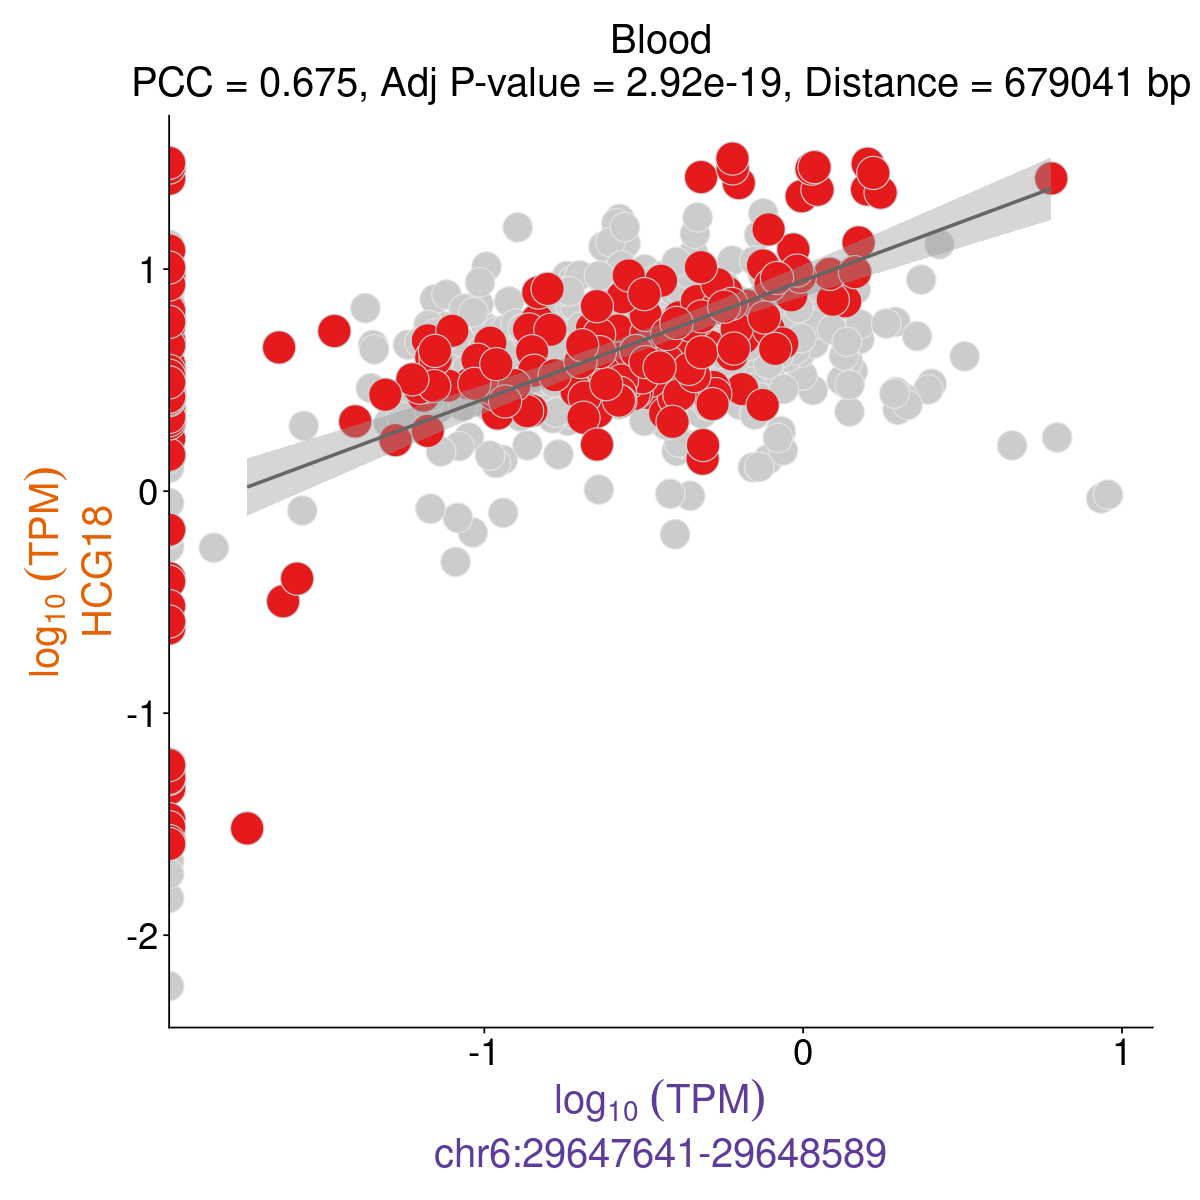

In [14]:
options(repr.plot.width=10, repr.plot.height=10) #HCG18:NR_024052.2~chr6:29647641-29648589
HCG18_blood <- plot_transcript_pairs_txptID_colB(genes_inter_bidir_filtered,
                             sig_pairs_path_DT_filt,
                            751,
                             "HCG18:NR_024052.2", "chr6:29647641-29648589", 
                             metadata_celltype_counted, 
                             mycolors,
                                 "blood") +
annotate("text", x = -0.5, y = -2, size=8, label = "rs425997", color='red')
#HCG18_blood

In [15]:
ggsave(HCG18_blood, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/HCG18_bidir_scatter_blood.pdf',
      bg = "transparent")

Warning message:
“Removed 65 rows containing non-finite values (stat_smooth).”


## UGCG:NM_003358.3~chr9:111895244-111896198

rs4979061 (chr9_111895439_C_T_b38)

[1] "UGCG:NM_003358.3"
[1] "chr9:111895244-111896198"
   transcript1_chrom transcript1_start transcript1_stop     transcript_1
1:              chr9         111896813        111935369 UGCG:NM_003358.3
   transcript1_score transcript1_strand transcript2_chrom transcript2_start
1:                 .                  +              chr9         111895244
   transcript2_stop             transcript_2 transcript2_score
1:        111896198 chr9:111895244-111896198               182
   transcript2_strand       pcc         pval     adj_p_BH nObs        t
1:                  . 0.8491973 2.580718e-59 2.239196e-55  209 23.13649
   distance_tss distance_tes position tissue percent_transcribed_both
1:        -1092       -39648 upstream  blood                 94.14414
[1] "Bidir: chr9:111895244-111896198"
[1] "Gene: UGCG:NM_003358.3"
[1] "Coeff: 0.849197268424419"
[1] "Adj p-val: 2.23919616336955e-55"
           UGCG:NM_003358.3 chr9:111895244-111896198
SRR7266931         26.00633                 22.86

Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”


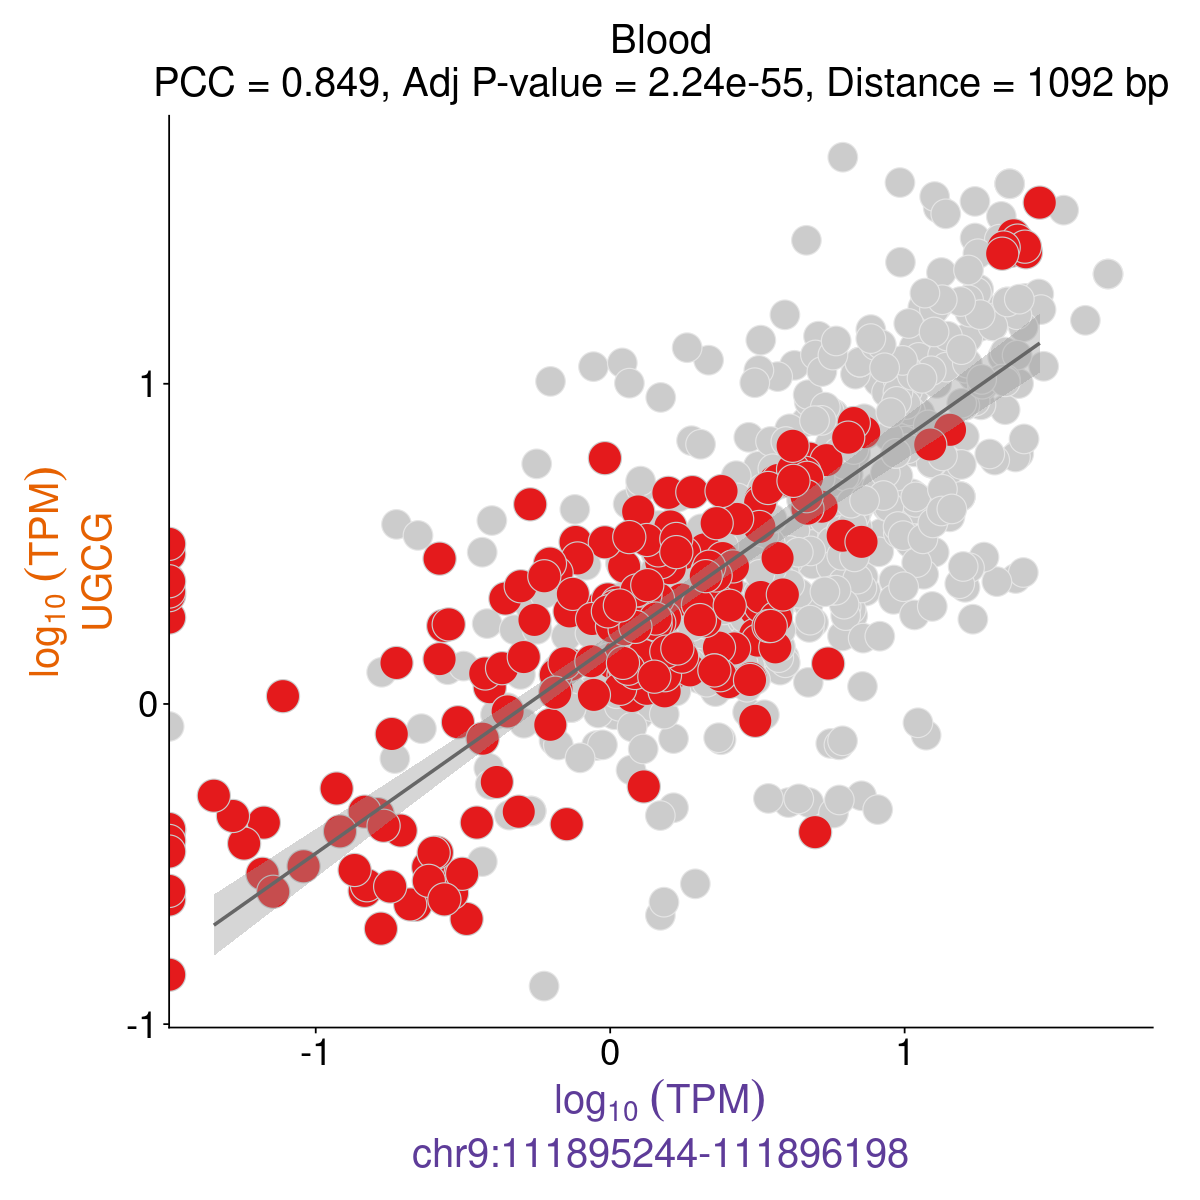

In [16]:
options(repr.plot.width=10, repr.plot.height=10)
UGCG_blood <- plot_transcript_pairs_txptID_colB(genes_inter_bidir_filtered,
                             sig_pairs_path_DT_filt,
                            751,
                             "UGCG:NM_003358.3", "chr9:111895244-111896198", 
                             metadata_celltype_counted, 
                             mycolors,
                                 "blood")  +
annotate("text", x = 0, y = 1.7, size=8, label = "rs4979061", color='red')



In [17]:
ggsave(UGCG_blood, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/UGCG_bidir_scatter_blood.pdf',
      bg = "transparent")

Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”


## DRAM1:NM_018370.3~chr12:101877045-101877339

rs11111068 (chr12_101877055_G_A_b38)

[1] "DRAM1:NM_018370.3"
[1] "chr12:101877045-101877339"
   transcript1_chrom transcript1_start transcript1_stop      transcript_1
1:             chr12         101877579        101923612 DRAM1:NM_018370.3
   transcript1_score transcript1_strand transcript2_chrom transcript2_start
1:                 .                  +             chr12         101877045
   transcript2_stop              transcript_2 transcript2_score
1:        101877339 chr12:101877045-101877339               175
   transcript2_strand       pcc         pval     adj_p_BH nObs        t
1:                  . 0.6630526 1.420299e-08 3.198227e-06   58 6.628389
   distance_tss distance_tes position tissue percent_transcribed_both
1:         -387       -46420 upstream uterus                      100
[1] "Bidir: chr12:101877045-101877339"
[1] "Gene: DRAM1:NM_018370.3"
[1] "Coeff: 0.663052634972507"
[1] "Adj p-val: 3.19822722839622e-06"
           DRAM1:NM_018370.3 chr12:101877045-101877339
SRR7266931         0.1769734           

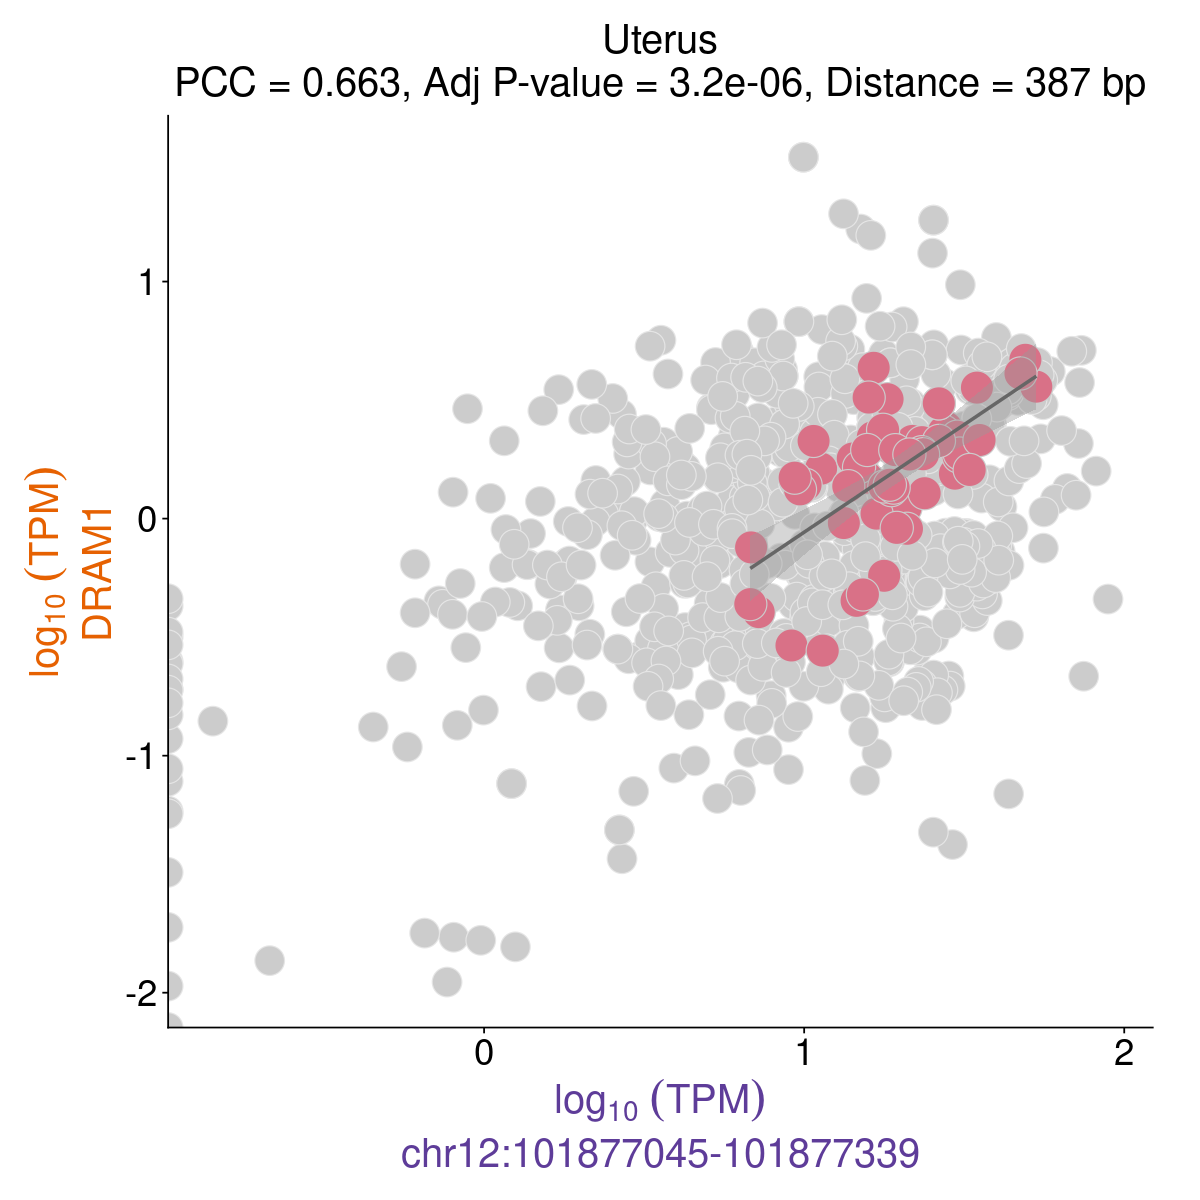

In [18]:
options(repr.plot.width=10, repr.plot.height=10)
DRAM_uterus <- plot_transcript_pairs_txptID_colB(genes_inter_bidir_filtered,
                             sig_pairs_path_DT_filt,
                            751,
                             "DRAM1:NM_018370.3", "chr12:101877045-101877339", 
                             metadata_celltype_counted, 
                             mycolors,
                                 "uterus") + 
annotate("text", x = 0.5, y = 1.5, size=8, label = "rs11111068", color='red')


In [19]:
ggsave(DRAM_uterus, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/DRAM1_bidir_scatter_uterus.pdf',
      bg = "transparent")

## TGFB1I1:NM_015927.5~chr16:31449677-31450571

rs75516957 (chr16_31450499_T_C_b38)

[1] "TGFB1I1:NM_015927.5"
[1] "chr16:31449677-31450571"
   transcript1_chrom transcript1_start transcript1_stop        transcript_1
1:             chr16          31473204         31477958 TGFB1I1:NM_015927.5
   transcript1_score transcript1_strand transcript2_chrom transcript2_start
1:                 .                  +             chr16          31449677
   transcript2_stop            transcript_2 transcript2_score
1:         31450571 chr16:31449677-31450571                 2
   transcript2_strand       pcc        pval    adj_p_BH nObs        t
1:                  . 0.6452138 0.001184949 0.009721656   22 3.776801
   distance_tss distance_tes position tissue percent_transcribed_both
1:       -23080       -27834 upstream  heart                      100
[1] "Bidir: chr16:31449677-31450571"
[1] "Gene: TGFB1I1:NM_015927.5"
[1] "Coeff: 0.64521376595827"
[1] "Adj p-val: 0.00972165596205131"
           TGFB1I1:NM_015927.5 chr16:31449677-31450571
SRR7266931           0.5651719               

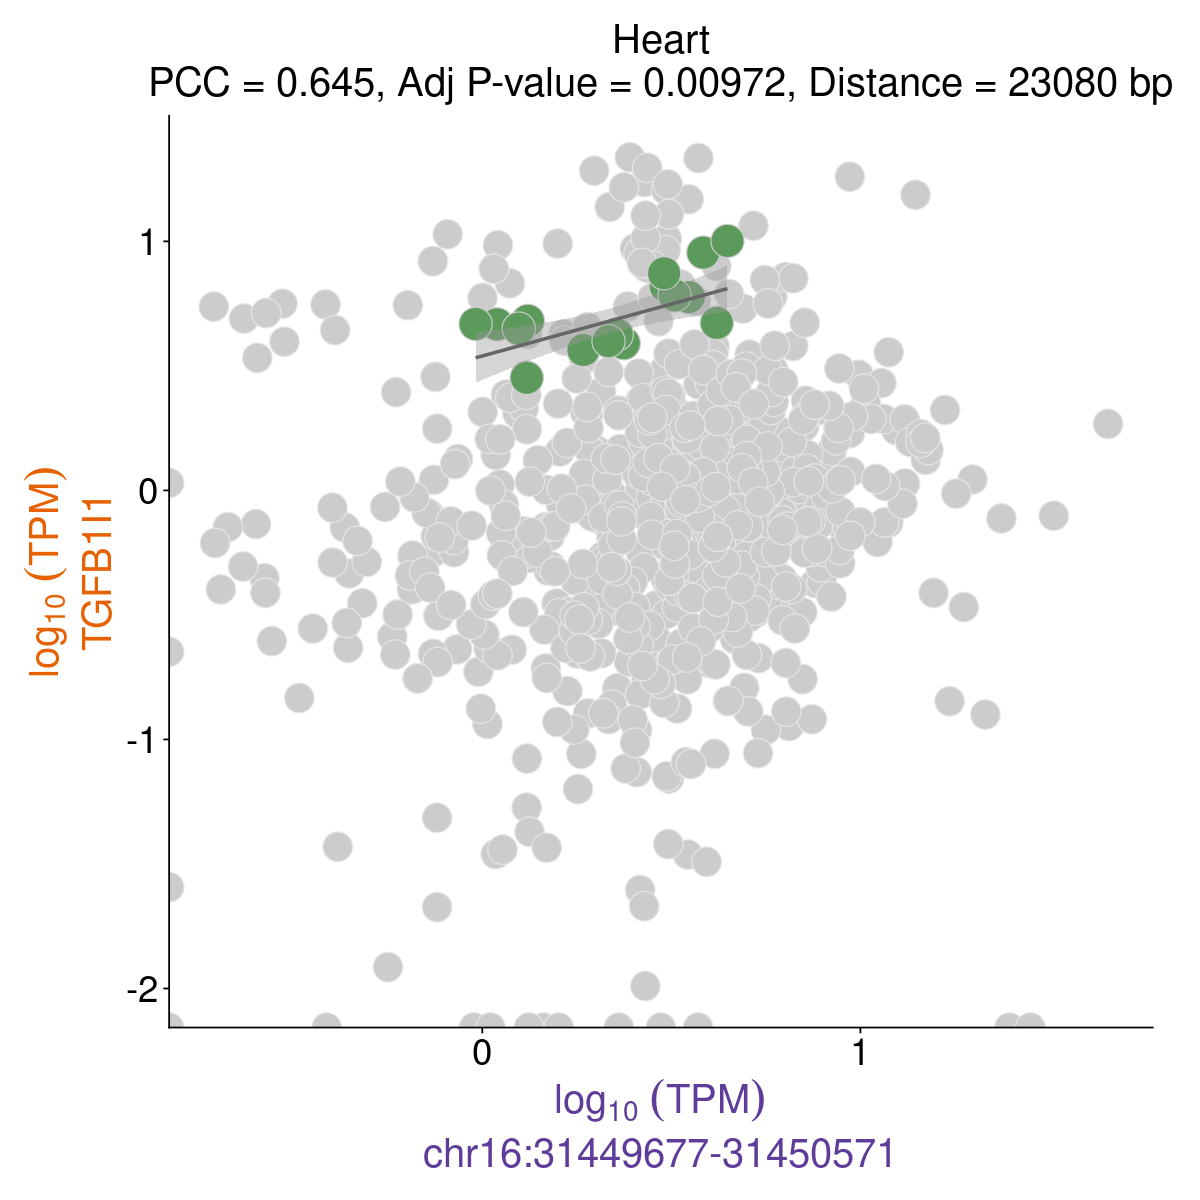

In [20]:
options(repr.plot.width=10, repr.plot.height=10)
TGFB1I1_heart <- plot_transcript_pairs_txptID_colB(genes_inter_bidir_filtered,
                             sig_pairs_path_DT_filt,
                            751,
                             "TGFB1I1:NM_015927.5", "chr16:31449677-31450571", 
                             metadata_celltype_counted, 
                             mycolors,
                                 "heart") +
annotate("text", x = 0.5, y = 1.5, size=8, label = "rs75516957", color='red')



In [21]:
ggsave(TGFB1I1_heart, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/TGFB1I1_bidir_scatter_heart.pdf',
      bg = "transparent")

## AGMAT:NM_024758.5~chr1:15603448-15603876


ENSG00000116771.5,chr1_15603594_G_GT_b38

[1] "AGMAT:NM_024758.5"
[1] "chr1:15603448-15603876"
   transcript1_chrom transcript1_start transcript1_stop      transcript_1
1:              chr1          15571698         15585051 AGMAT:NM_024758.5
   transcript1_score transcript1_strand transcript2_chrom transcript2_start
1:                 .                  -              chr1          15603448
   transcript2_stop           transcript_2 transcript2_score transcript2_strand
1:         15603876 chr1:15603448-15603876               145                  .
          pcc         pval     adj_p_BH nObs        t distance_tss distance_tes
1: -0.7721522 2.384644e-06 0.0006650942   27 6.075751       -18611       -31964
   position tissue percent_transcribed_both
1: upstream embryo                      100
[1] "Bidir: chr1:15603448-15603876"
[1] "Gene: AGMAT:NM_024758.5"
[1] "Coeff: -0.772152194595907"
[1] "Adj p-val: 0.00066509422392317"
           AGMAT:NM_024758.5 chr1:15603448-15603876
SRR7266931         0.1261962               24.38486


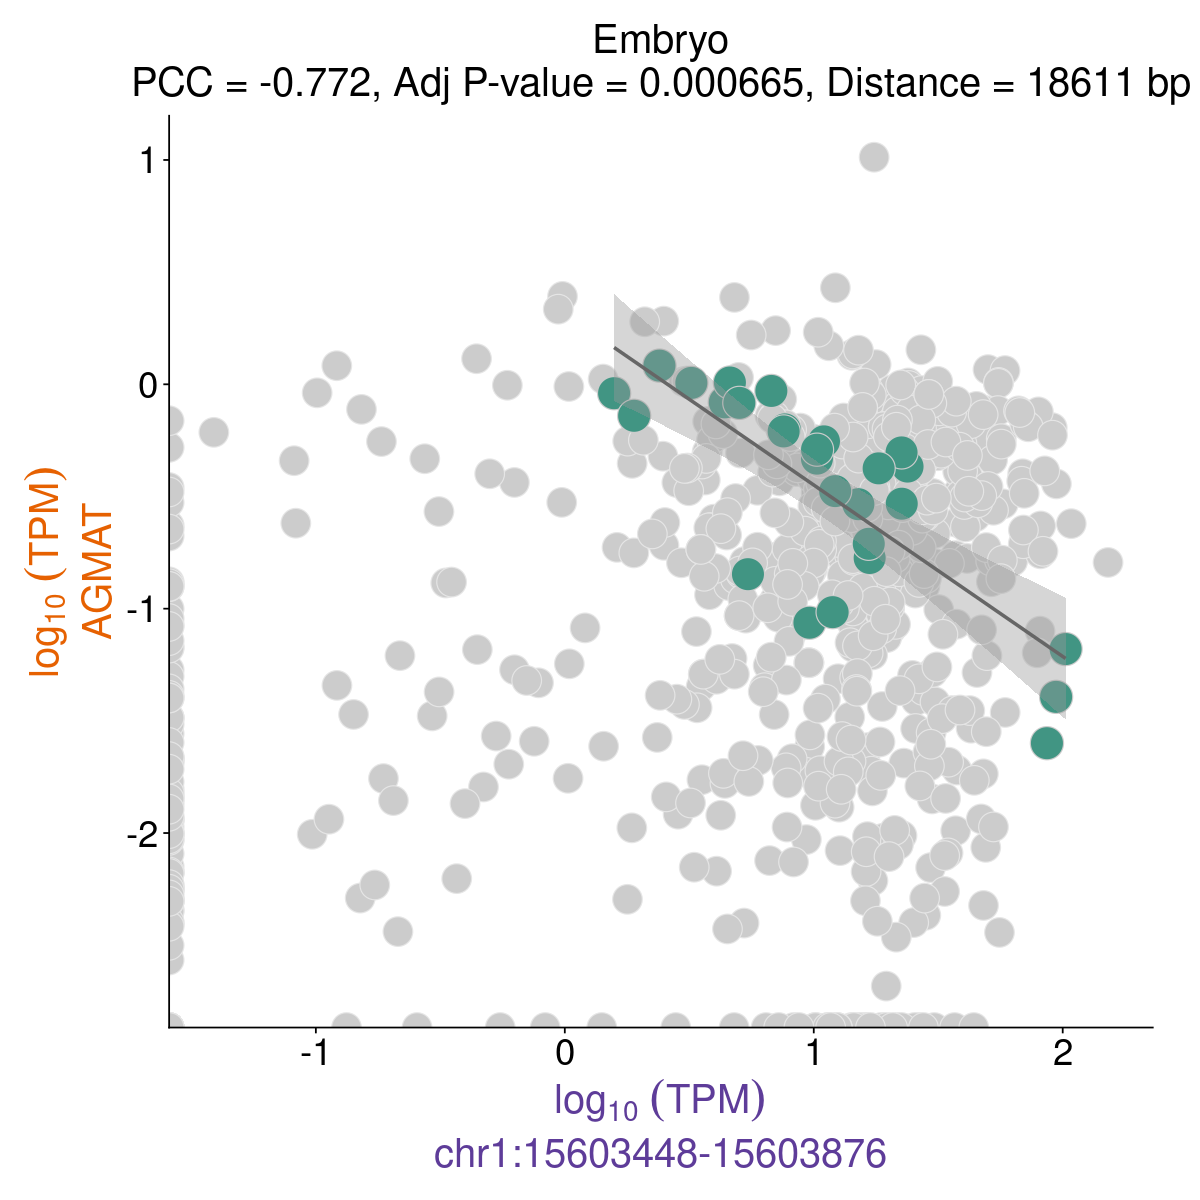

In [22]:
options(repr.plot.width=10, repr.plot.height=10)
AGMAT_embryo <- plot_transcript_pairs_txptID_colB(genes_inter_bidir_filtered,
                             sig_pairs_path_DT_filt,
                            751,
                             "AGMAT:NM_024758.5", "chr1:15603448-15603876", 
                             metadata_celltype_counted, 
                             mycolors,
                                 "embryo")  +
annotate("text", x = 0.5, y = 1, size=8, label = "rs200263397", color='red')

In [23]:
ggsave(AGMAT_embryo, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/AGMAT_bidir_scatter_embryo.pdf',
      bg = "transparent")

# Pair Example - `Non-GTEx`

## LINC01661:NR_147165.1~chr1:106802282-106804238

[1] "LINC01661:NR_147165.1"
[1] "chr1:106802282-106804238"
   transcript1_chrom transcript1_start transcript1_stop          transcript_1
1:              chr1         106818238        106838193 LINC01661:NR_147165.1
   transcript1_score transcript1_strand transcript2_chrom transcript2_start
1:                 .                  +              chr1         106802282
   transcript2_stop             transcript_2 transcript2_score
1:        106804238 chr1:106802282-106804238                 7
   transcript2_strand       pcc         pval    adj_p_BH nObs        t
1:                  . 0.9039158 3.101028e-54 1.22768e-50  144 25.18386
   distance_tss distance_tes position tissue percent_transcribed_both
1:       -14978       -34933 upstream breast                 90.56604
[1] "Bidir: chr1:106802282-106804238"
[1] "Gene: LINC01661:NR_147165.1"
[1] "Coeff: 0.903915815944744"
[1] "Adj p-val: 1.22768028044055e-50"
           LINC01661:NR_147165.1 chr1:106802282-106804238
SRR7266931           0.000

Warning message:
“Removed 15 rows containing non-finite values (stat_smooth).”


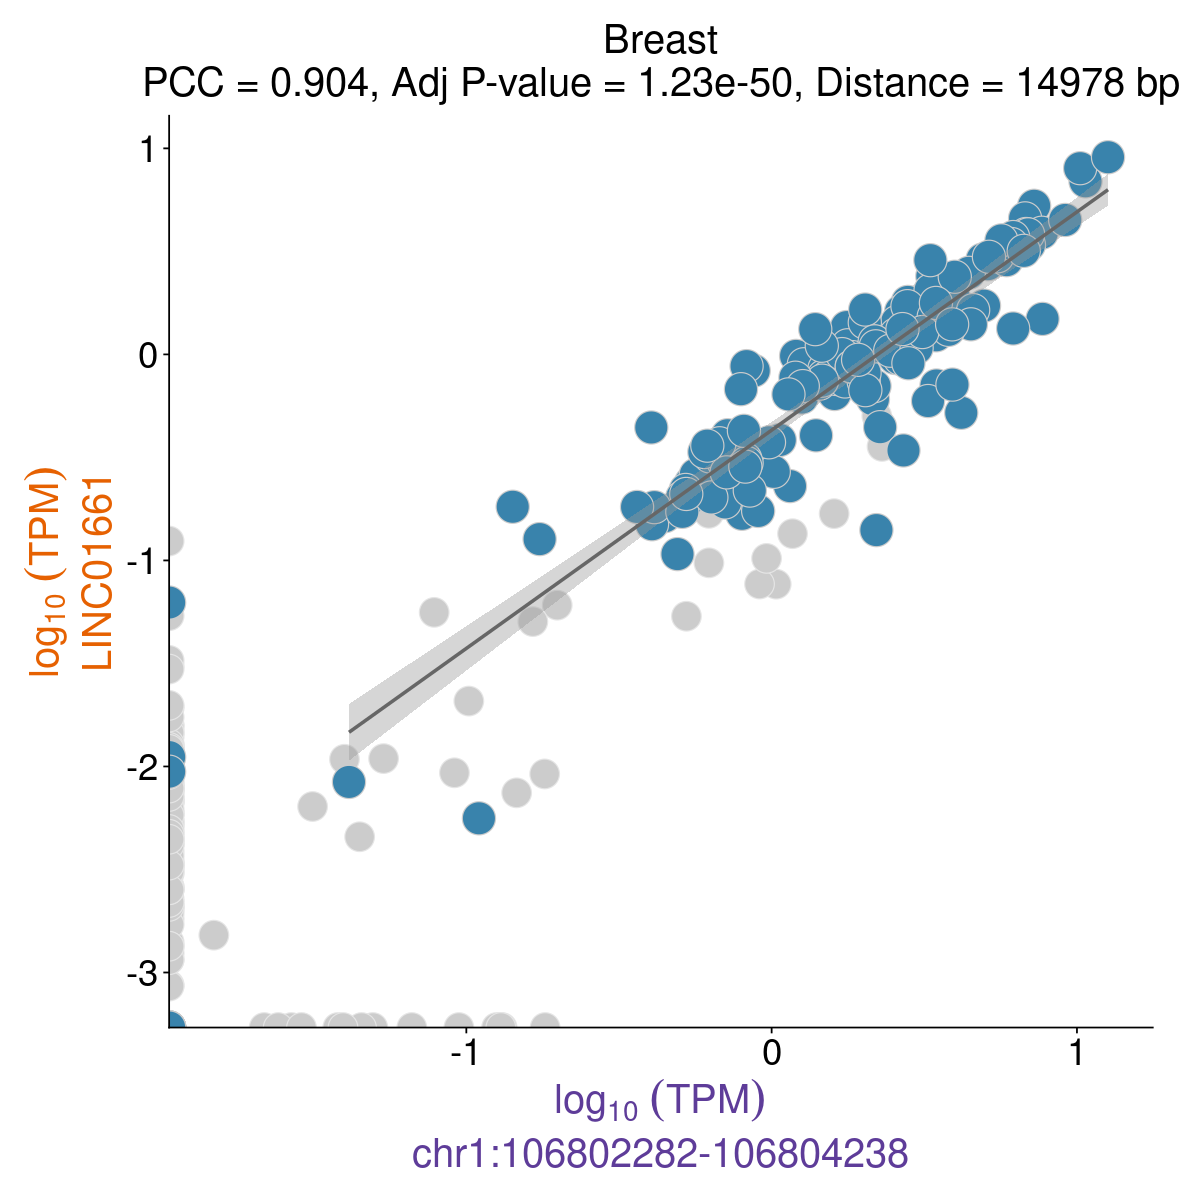

In [24]:
options(repr.plot.width=10, repr.plot.height=10)
LINC01661_breast <- plot_transcript_pairs_txptID_colB(genes_inter_bidir_filtered,
                             sig_pairs_path_DT_filt,
                            751,
                             "LINC01661:NR_147165.1", "chr1:106802282-106804238", 
                             metadata_celltype_counted, 
                             mycolors,
                                 "breast")

In [25]:
ggsave(LINC01661_breast, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/LINC01661_bidir_scatter_breast_NOrs.pdf',
      bg = "transparent")

Warning message:
“Removed 15 rows containing non-finite values (stat_smooth).”


# Pair Example - `Non-significant`

## ARFGAP3:NM_014570.5~chr22:42867917-42868245

[1] "ARFGAP3:NM_014570.5"
[1] "chr22:42867917-42868245"
   transcript1_chrom transcript1_start transcript1_stop        transcript_1
1:             chr22          42796501         42857273 ARFGAP3:NM_014570.5
   transcript1_score transcript1_strand transcript2_chrom transcript2_start
1:                 .                  -             chr22          42867917
   transcript2_stop            transcript_2 transcript2_score
1:         42868245 chr22:42867917-42868245                 2
   transcript2_strand         pcc      pval  adj_p_BH nObs        t
1:                  . -0.02078648 0.7591555 0.8703165  220 0.306975
   distance_tss distance_tes position tissue percent_transcribed_both
1:       -10808       -71580 upstream  blood                  99.0991
[1] "Bidir: chr22:42867917-42868245"
[1] "Gene: ARFGAP3:NM_014570.5"
[1] "Coeff: -0.0207864750680497"
[1] "Adj p-val: 0.870316497758933"
           ARFGAP3:NM_014570.5 chr22:42867917-42868245
SRR7266931            1.248532                10

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”


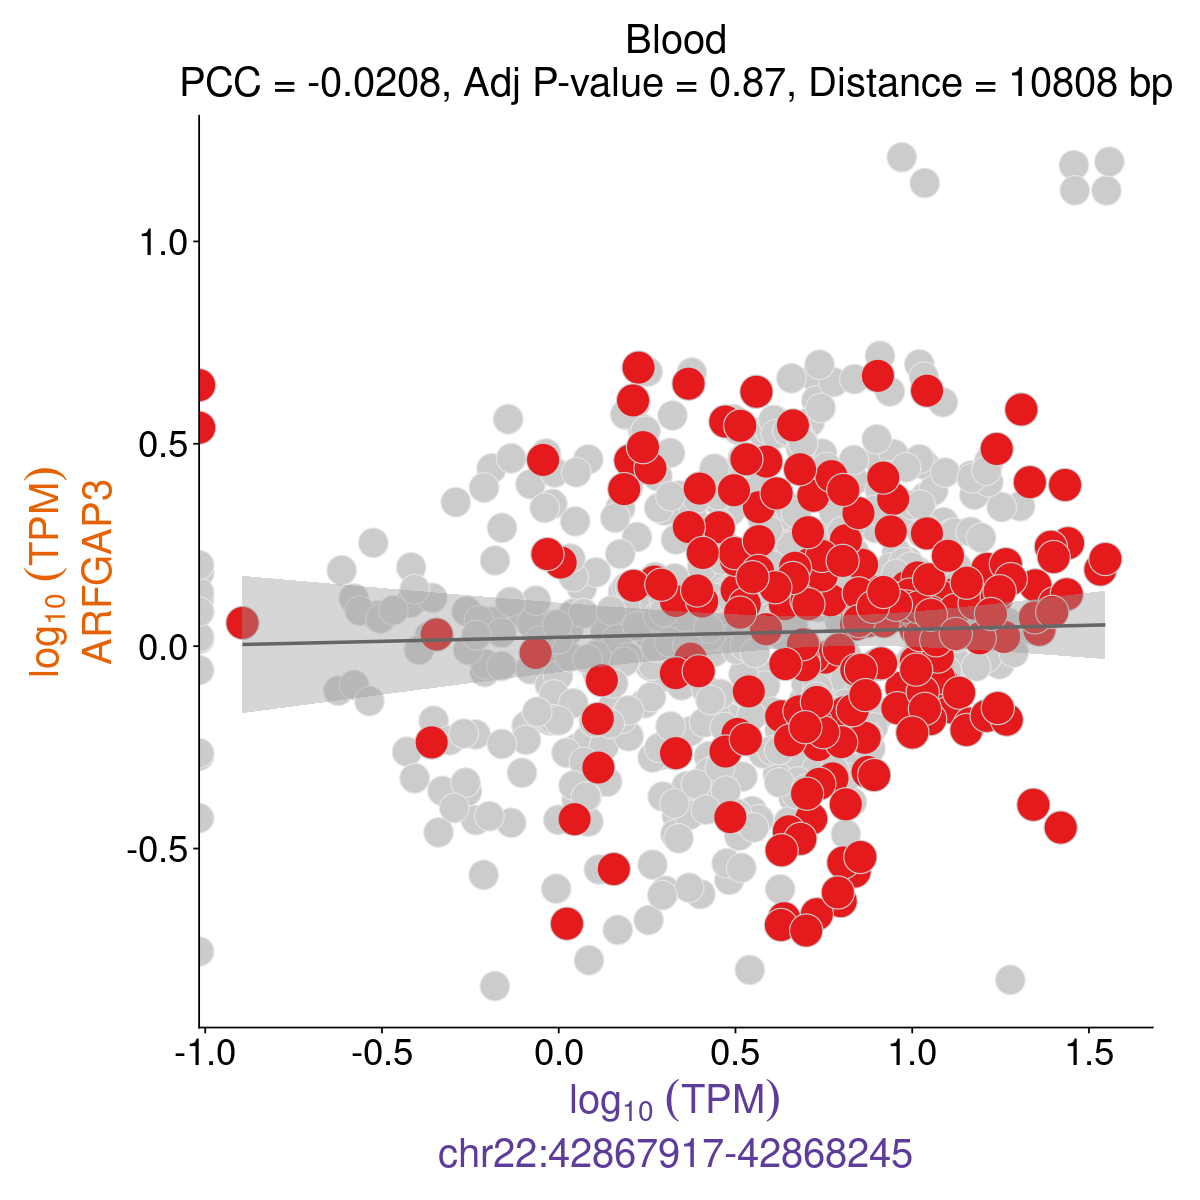

In [26]:
options(repr.plot.width=10, repr.plot.height=10)
ARFGAP3_blood <- plot_transcript_pairs_txptID_colB(genes_inter_bidir_filtered,
                             non_sig_pairs_chr22,
                            751,
                             "ARFGAP3:NM_014570.5", "chr22:42867917-42868245", 
                             metadata_celltype_counted, 
                             mycolors,
                                 "blood")

In [27]:
ggsave(ARFGAP3_blood, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/ARFGAP3_bidir_scatter_blood_NOsig.pdf',
      bg = "transparent")

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”


# Session Information

In [28]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] scales_1.2.1       data.table_1.14.2  RColorBrewer_1.1-3 cowplot_1.1.1     
[5] ggplot2_3.3.6     

loaded via a namespace (and not attached):
 [1] pillar_1.8.1      compiler_3.6.0    R.methodsS3_1.8.2 R.utils_2.12.0   
 [5] base64enc_0.1-3   tools_3.6.0       digest_0.6.29     uuid_1.1-0       
 [9] lattice_0.20-38   nlme_3.1-13